Aluna: Monica Maria Funk Drechsler - NUSP: 11275391

# EP 4 - Autoencoders

Começamos usando como referência principal o notebook (muito bom) deste engenheiro de software da Google, adaptando para a MNIST (https://www.kaggle.com/code/ohseokkim/base-denoising-autoencoder-dimension-reduction/notebook) e depois o modelo de Variational Autoencoder fornecido pelo keras (https://keras.io/examples/generative/vae/). Como a referência é escrita em keras, utilizamos esta linguagem em todo o EP, mas fiz uma versão traduzida para Pytorch : https://colab.research.google.com/drive/1kStCdwxG_1V3onKVxTAF9t4iG73gX4se?usp=sharing

## Bibliotecas e Instalações



In [ ]:
!pip install umap-learn[plot]
!pip install "dask[dataframe]"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 7.1 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 7.7 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt ## Para fazer gráficos
import numpy as np # Para contas de algebra linear
import pandas as pd # Para operar com dataset
import tensorflow as tf # Para fazer upload do MNIST mais fácil
import seaborn as sns # Biblioteca necessária para os gráficos do umap
import torch #
from torchvision import datasets #Para importar datasets
from torchvision import transforms #E transformar eles em tenosres
import umap.plot # Para fazer gráficos 2D e 3D das distribuições de dados


from sklearn.metrics import accuracy_score, precision_score, recall_score #Formas de medida
from sklearn.model_selection import train_test_split #Separar os dados
from tensorflow.keras import layers, losses #Bibliotecas específicas do Keras
from tensorflow.keras.models import Model #Upload de bibliotecas específicas

/usr/local/lib/python3.10/dist-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/usr/local/lib/python3.10/dist-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)
/usr/local/lib/python3.10/dist-packages/numba/np/ufunc/dufunc.py:343: NumbaWarning: Compilation requested for previously compiled argument types ((uint32,)). This has no effect and perhaps indicates a bug in the calling code (compiling a ufunc more than once for the same signature
  warnings.warn(msg, errors.NumbaWarning)


## Upload e visualização do Dataset - MNIST

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path='mnist.npz')

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


In [ ]:
x_train_flat = x_train.reshape(x_train.shape[0], -1)


In [ ]:
labels = { 0: '0', 1: '1', 2: '2', 3: '3', 4: '4',
          5: '5', 6: '6', 7: '7', 8 : '8', 9 : '9'}

In [ ]:
y_train = pd.DataFrame(y_train,columns=['class'])
y_train.replace({'class': labels}, inplace=True)

<Axes: >

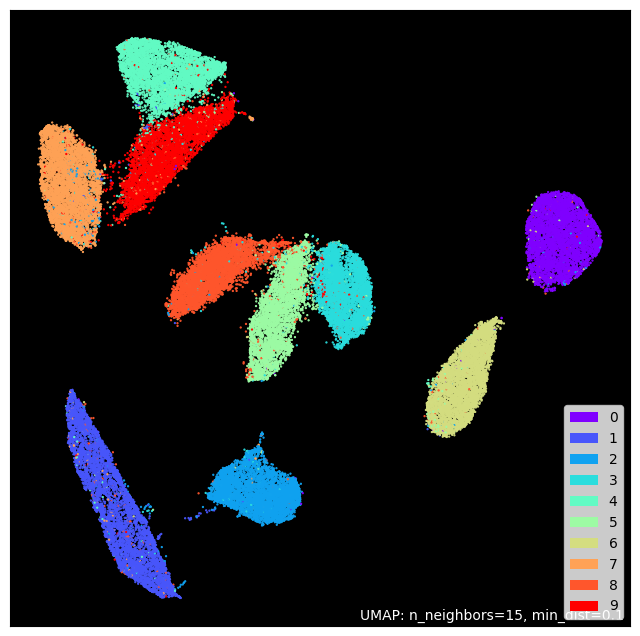

In [ ]:
import umap.plot
mapper_org = umap.UMAP().fit(x_train_flat)
umap.plot.points(mapper_org, labels=y_train["class"], theme='fire')

In [ ]:
import plotly
import plotly.express as px
from umap import UMAP

umap_3d = UMAP(n_components=3, init='random', random_state=0)
x_umap = umap_3d.fit_transform(x_train_flat)
umap_df = pd.DataFrame(x_umap)
new_df = pd.concat([umap_df,y_train["class"]],axis=1)
fig = px.scatter_3d(
    new_df, x=0, y=1, z=2,
    color='class', labels={'color': 'class'}
)
fig.update_traces(marker_size=1)
fig.show()

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Uma coisa interessante se trata da proximidade dos dados referentes ao número 4, 7 e 9. No entanto, ao pesquisar sobre, recaí no site a seguir: https://stackoverflow.com/questions/32565438/why-does-my-neural-network-trained-on-mnist-data-set-not-predict-7-and-9-correct onde mostra que para algumas amostras de 4, 9 e 7 estão muito próximas.

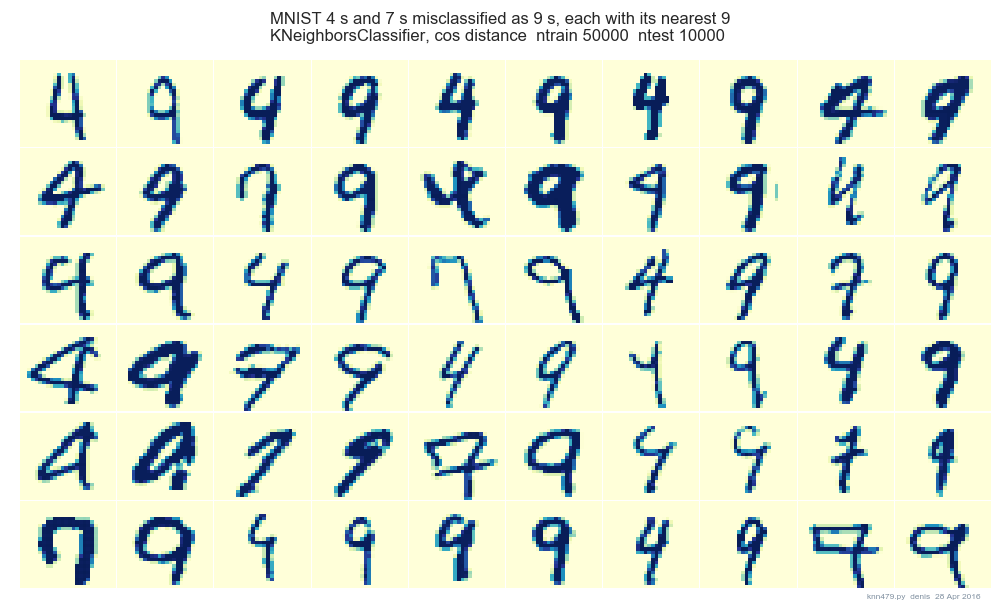


## Modelo Autoencoder


In [ ]:
latent_dim = 64

class Autoencoder(Model):
  def __init__(self, encoding_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),                  # (1,784)
      layers.Dense(latent_dim, activation='relu'),
    ])                                   # (1,784)(784,64) => (1,64)
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))           # (1,64)(64,784) => (1,784) => (1,28,28)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)


In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0441 - val_loss: 0.0093
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0081 - val_loss: 0.0054
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0053 - val_loss: 0.0046
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0046 - val_loss: 0.0043
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0044 - val_loss: 0.0041
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0042 - val_loss: 0.0041
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0041 - val_loss: 0.0039
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0040 - val_loss: 0.0039


In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

In [ ]:
y_test = pd.DataFrame(y_test,columns=['class'])
y_test.replace({'class':labels}, inplace=True)

<Axes: >

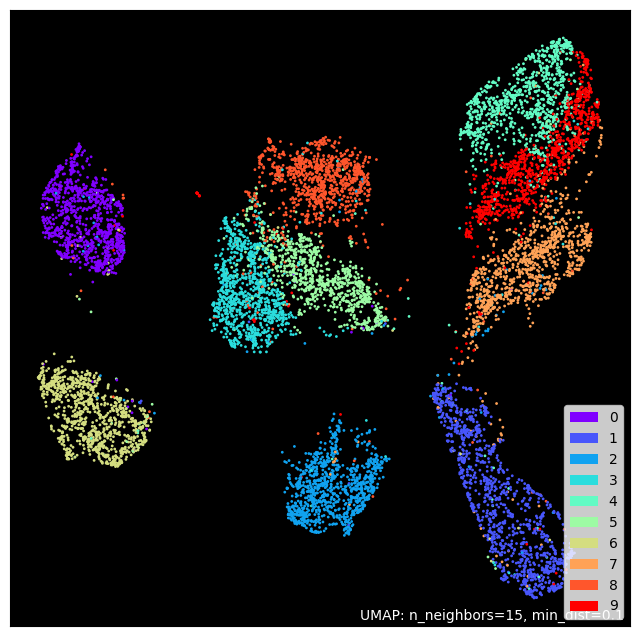

In [ ]:
mapper = umap.UMAP().fit(encoded_imgs)
umap.plot.points(mapper, labels=y_test["class"],theme='fire')

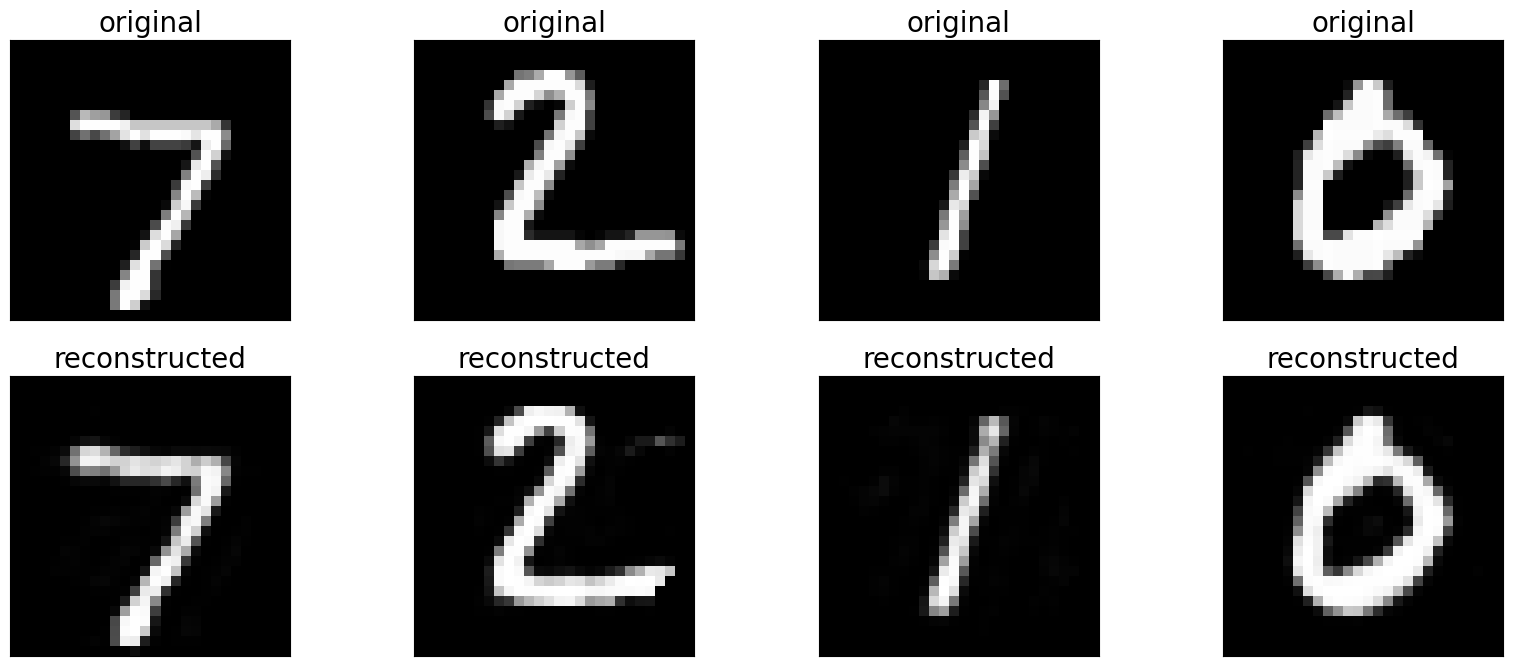

In [ ]:
n = 4
plt.figure(figsize=(20, 8))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  ax.cla()
  plt.imshow(x_test[i].squeeze())
  plt.title("original",fontsize=20)
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  ax.cla()
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed",fontsize=20)
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## E se eu adicionar mais camadas?

In [ ]:
latent_dim = 64

class Autoencoder2(Model):
  def __init__(self, encoding_dim):
    super(Autoencoder2, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),                  # (1,784)
      layers.Dense(128, activation ='relu'), #(1,784)(784,128) => (1,128)
      layers.Dense(latent_dim, activation='relu'),
    ])                                   # (1,128)(128,64) => (1,64)
    self.decoder = tf.keras.Sequential([
      layers.Dense(128, activation='relu'), #(1,64)(64,128) => (1,128)
      layers.Dense(784, activation='sigmoid'), #(1,128)(128,784)
      layers.Reshape((28, 28))           #(1,784) => (1,28,28)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder2(latent_dim)

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0406 - val_loss: 0.0113
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0106 - val_loss: 0.0081
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0081 - val_loss: 0.0069
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0069 - val_loss: 0.0060
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0062 - val_loss: 0.0058
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0057 - val_loss: 0.0052
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0053 - val_loss: 0.0049
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0050 - val_loss: 0.0048
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0048 - val_loss: 0.0047
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0047 - val_loss: 0.0045


In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

In [ ]:
y_test = pd.DataFrame(y_test,columns=['class'])
y_test.replace({'class':labels}, inplace=True)

<Axes: >

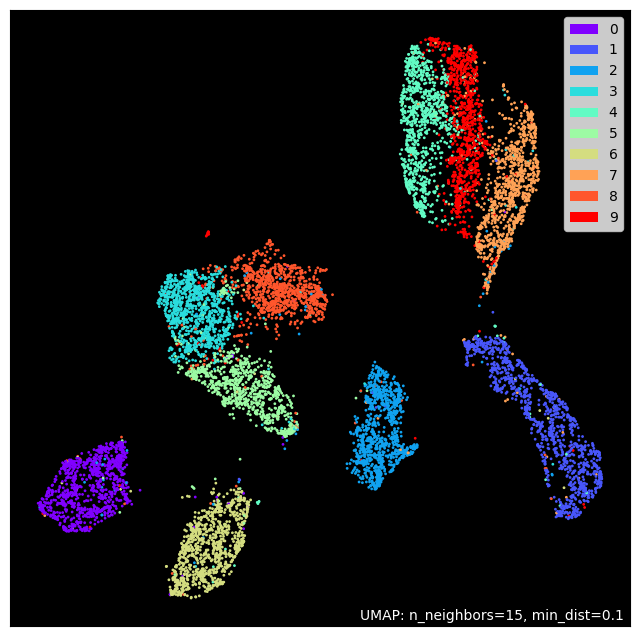

In [ ]:
mapper = umap.UMAP().fit(encoded_imgs)
umap.plot.points(mapper, labels=y_test["class"],theme='fire')

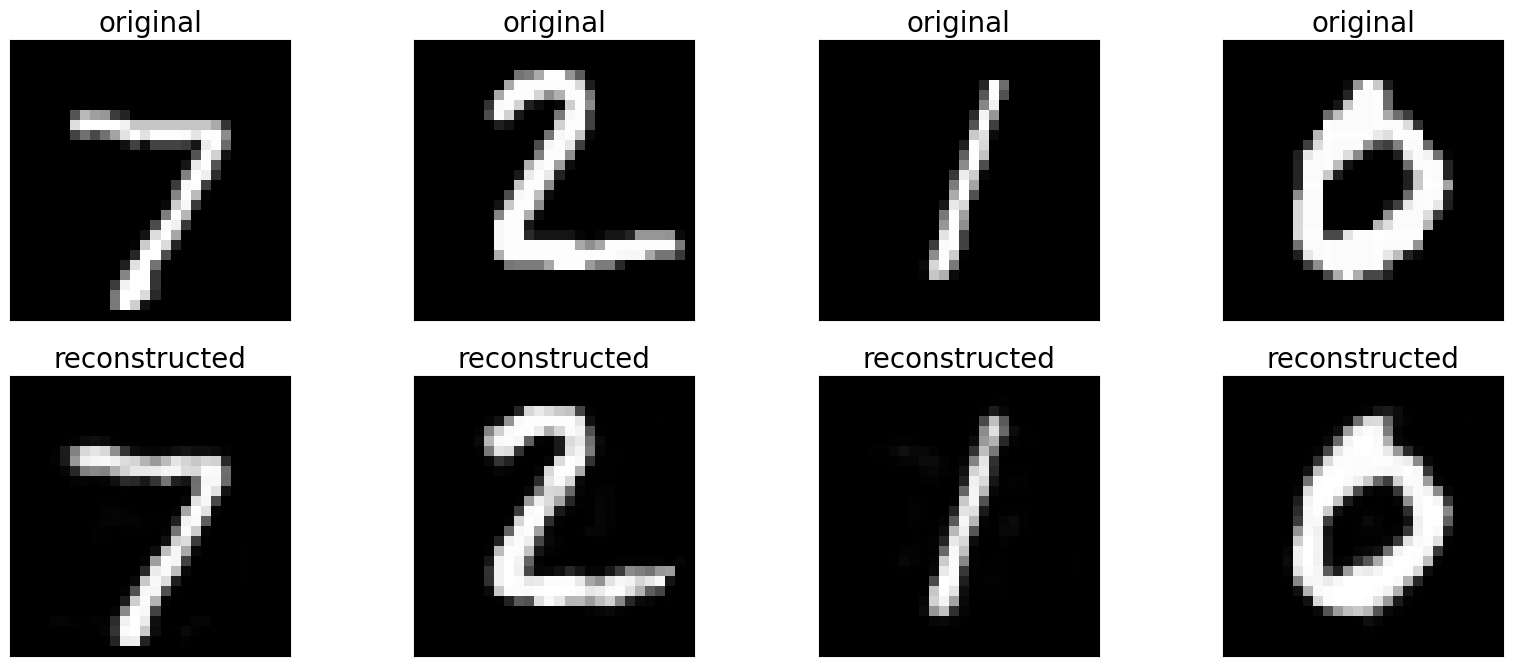

In [ ]:
n = 4
plt.figure(figsize=(20, 8))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  ax.cla()
  plt.imshow(x_test[i].squeeze())
  plt.title("original",fontsize=20)
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  ax.cla()
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed",fontsize=20)
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## Denoising AutoEncoder

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data(path='mnist.npz')

In [ ]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


In [ ]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape)
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape)

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

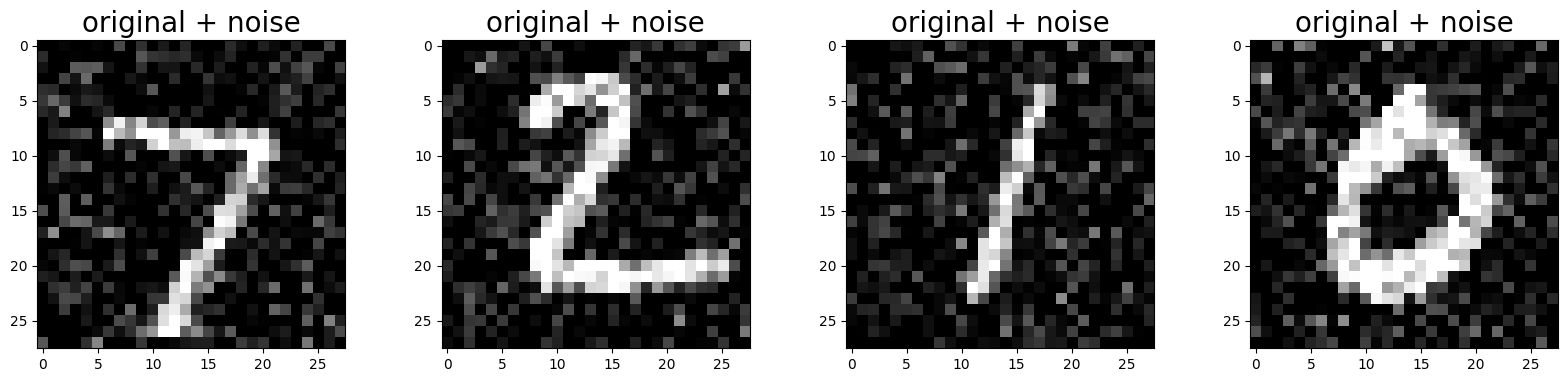

In [ ]:
n = 4
plt.figure(figsize=(20, 4))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise",fontsize=20)
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

In [ ]:
x_train_noisy_flat = x_train.reshape(x_train_noisy.shape[0], -1)

In [ ]:
y_train = pd.DataFrame(y_train,columns=['class'])
y_train.replace({'class':labels}, inplace=True)

<Axes: >

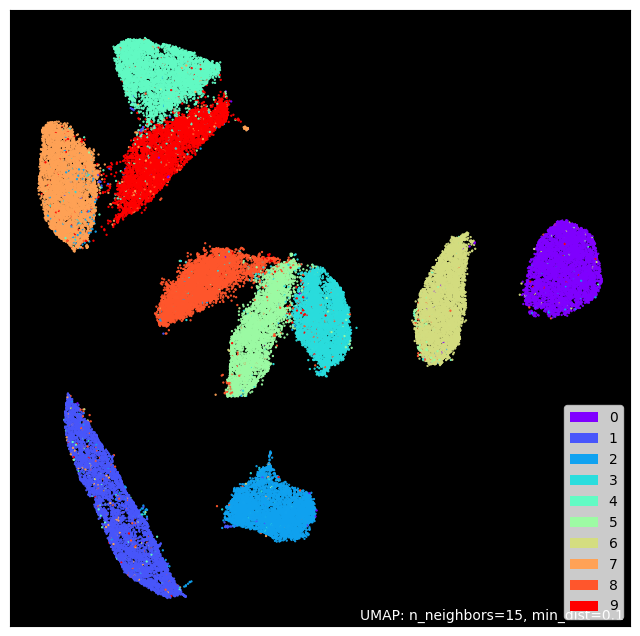

In [ ]:
mapper_noisy = umap.UMAP().fit(x_train_noisy_flat)
umap.plot.points(mapper_noisy, labels=y_train['class'], theme='fire')

Enquanto isto, para o dataset original..

In [ ]:
x_train_flat = x_train.reshape(x_train.shape[0], -1)

<Axes: >

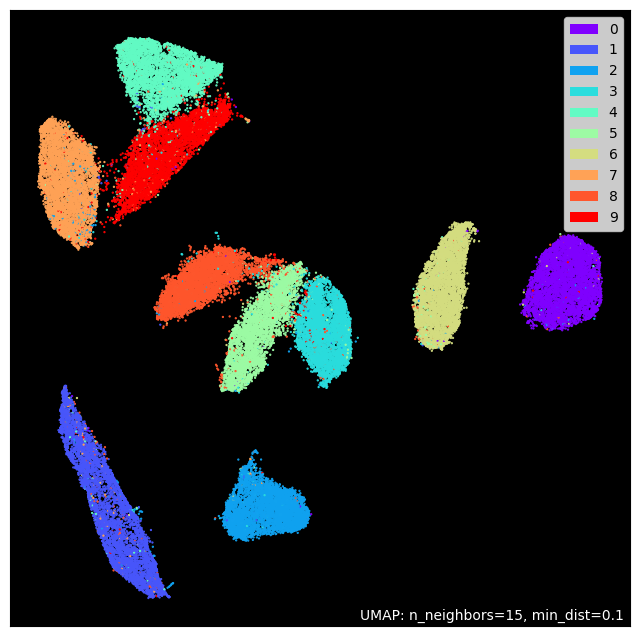

In [ ]:
mapper_org = umap.UMAP().fit(x_train_flat)
umap.plot.points(mapper_org, labels=y_train['class'], theme='fire')

Utilizando o mesmo modelo inicial

In [ ]:
latent_dim = 64

class Autoencoder(Model):
  def __init__(self, encoding_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),                  # (1,784)
      layers.Dense(latent_dim, activation='relu'),
    ])                                   # (1,784)(784,64) => (1,64)
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))           # (1,64)(64,784) => (1,784) => (1,28,28)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder(latent_dim)

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))


Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0442 - val_loss: 0.0110
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0101 - val_loss: 0.0079
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0078 - val_loss: 0.0070
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0070 - val_loss: 0.0067
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0067 - val_loss: 0.0064
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0065 - val_loss: 0.0064
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0064 - val_loss: 0.0062
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0062 - val_loss: 0.0062
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0062 - val_loss: 0.0061
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0062 - val_loss: 0.0061


In [ ]:
autoencoder.encoder.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)                  │ (32, 784)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (32, 64)                    │          50,240 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,240 (196.25 KB)

 Trainable params: 50,240 (196.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
autoencoder.decoder.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                      │ (32, 784)                   │          50,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_2 (Reshape)                  │ (32, 28, 28)                │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,960 (199.06 KB)

 Trainable params: 50,960 (199.06 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

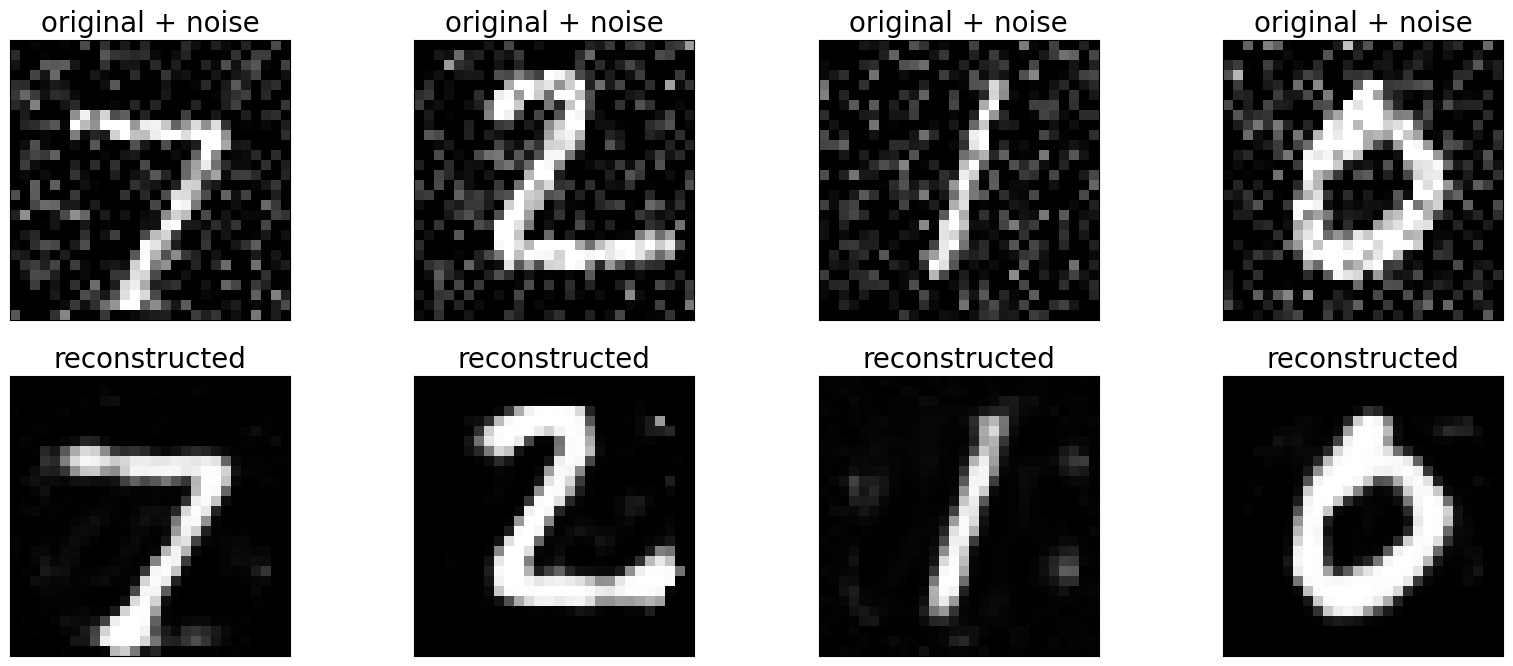

In [ ]:
n = 4
plt.figure(figsize=(20, 8))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise",fontsize=20)
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed",fontsize=20)
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

In [ ]:
y_test = pd.DataFrame(y_test,columns=['class'])
y_test.replace({'class':labels}, inplace=True)

<Axes: >

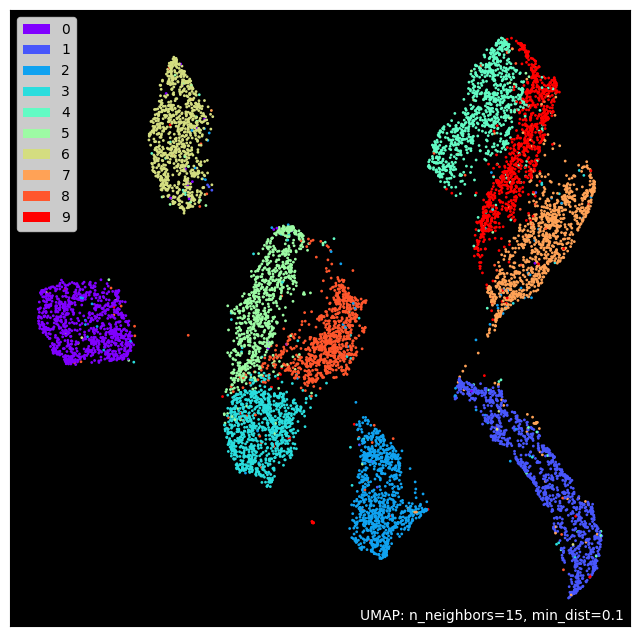

In [ ]:
mapper = umap.UMAP().fit(encoded_imgs)
umap.plot.points(mapper, labels=y_test["class"],theme='fire')

Adicionando camadas

In [ ]:
latent_dim = 64

class Autoencoder2(Model):
  def __init__(self, encoding_dim):
    super(Autoencoder2, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),                  # (1,784)
      layers.Dense(128, activation ='relu'), #(1,784)(784,128) => (1,128)
      layers.Dense(latent_dim, activation='relu'),
    ])                                   # (1,128)(128,64) => (1,64)
    self.decoder = tf.keras.Sequential([
      layers.Dense(128, activation='relu'), #(1,64)(64,128) => (1,128)
      layers.Dense(784, activation='sigmoid'), #(1,128)(128,784)
      layers.Reshape((28, 28))           #(1,784) => (1,28,28)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Autoencoder2(latent_dim)

In [ ]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [ ]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0399 - val_loss: 0.0106
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0101 - val_loss: 0.0081
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0080 - val_loss: 0.0069
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0068 - val_loss: 0.0062
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0062 - val_loss: 0.0057
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0058 - val_loss: 0.0056
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0056 - val_loss: 0.0052
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.0053 - val_loss: 0.0051
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 2ms/step - loss: 0.0051 - val_loss: 0.0050


In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

In [ ]:
y_test = pd.DataFrame(y_test,columns=['class'])
y_test.replace({'class':labels}, inplace=True)

<Axes: >

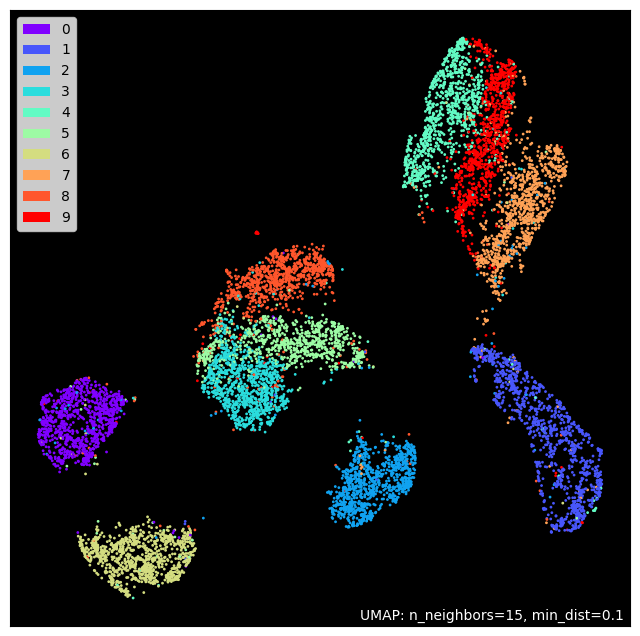

In [ ]:
mapper = umap.UMAP().fit(encoded_imgs)
umap.plot.points(mapper, labels=y_test["class"],theme='fire')

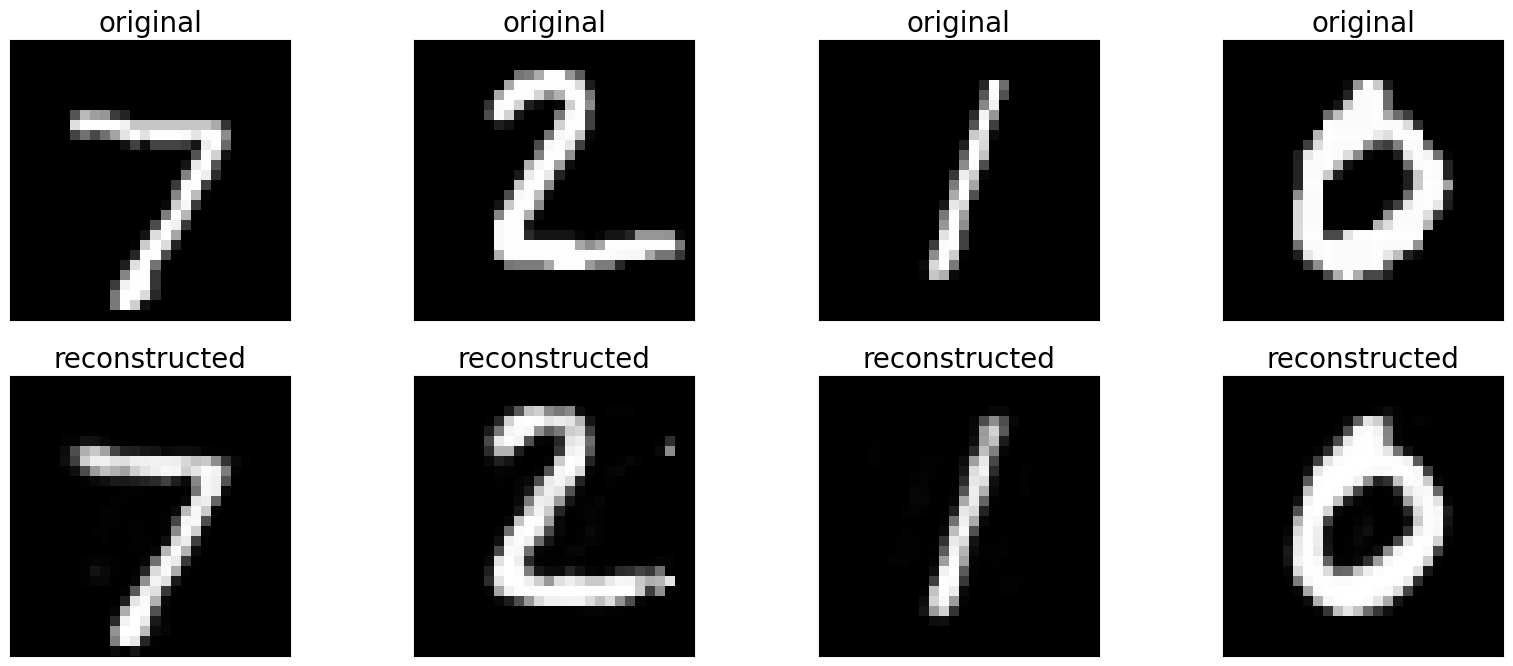

In [ ]:
n = 4
plt.figure(figsize=(20, 8))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  ax.cla()
  plt.imshow(x_test[i].squeeze())
  plt.title("original",fontsize=20)
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  ax.cla()
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed",fontsize=20)
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
class Denoise(Model):
  def __init__(self):
    super(Denoise, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Input(shape=(28, 28,1)),
      layers.Conv2D(16, (3,3), activation='relu', padding='same', strides=2),
      layers.Conv2D(8, (3,3), activation='relu', padding='same', strides=2)])

    self.decoder = tf.keras.Sequential([
      layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
      layers.Conv2D(1, kernel_size=(3,3), activation='sigmoid', padding='same')])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = Denoise()

In [ ]:
autoencoder.encoder.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 14, 14, 16)          │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 7, 7, 8)             │           1,160 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,320 (5.16 KB)

 Trainable params: 1,320 (5.16 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
autoencoder.decoder.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_transpose_2 (Conv2DTranspose) │ (32, 14, 14, 8)             │             584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (32, 28, 28, 16)            │           1,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (32, 28, 28, 1)             │             145 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,897 (7.41 KB)

 Trainable params: 1,897 (7.41 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - loss: 0.1748 - val_loss: 0.0752
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0751 - val_loss: 0.0735
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0739 - val_loss: 0.0728
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0732 - val_loss: 0.0723
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0727 - val_loss: 0.0717
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0721 - val_loss: 0.0713
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0718 - val_loss: 0.0711
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0715 - val_loss: 0.0710
Epoch 9/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0715 - val_loss: 0.0709
Epoch 10/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0713 - val_loss: 0.0708


In [ ]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

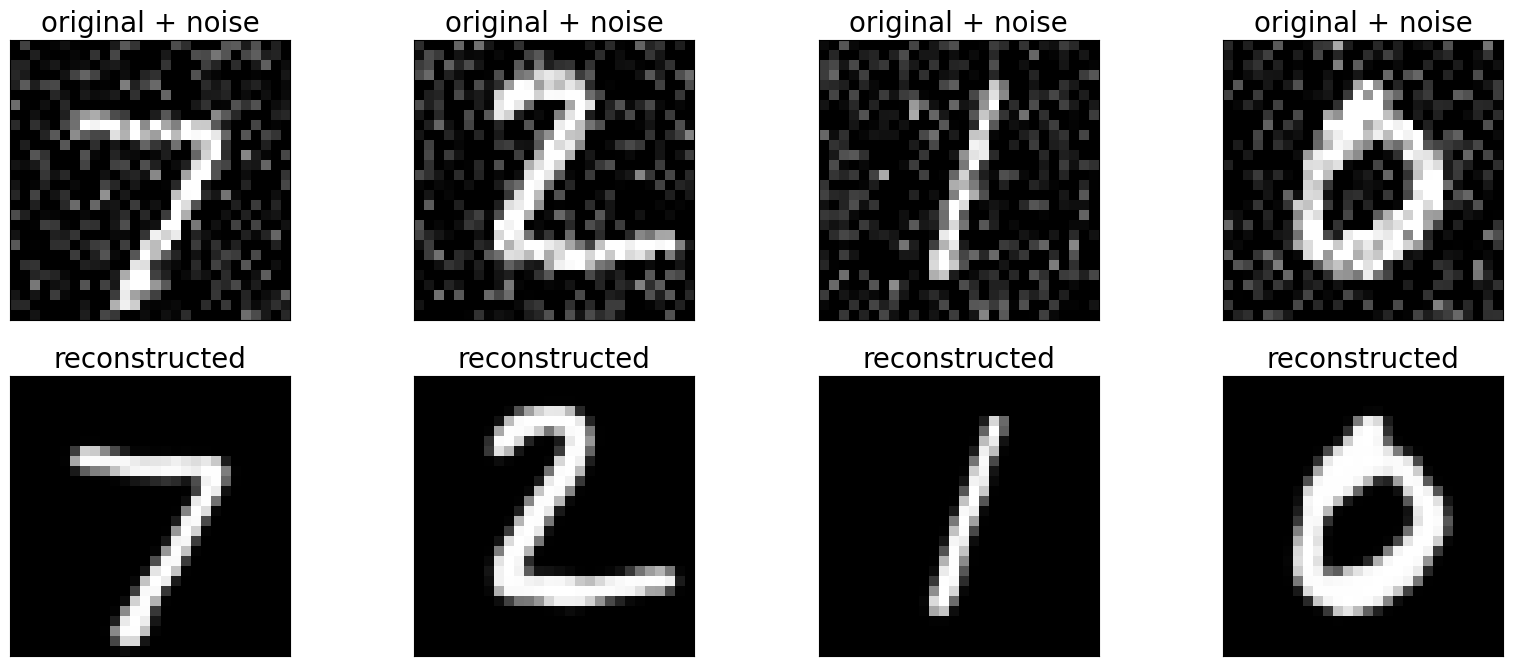

In [ ]:
n = 4
plt.figure(figsize=(20, 8))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise",fontsize=20)
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed",fontsize=20)
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

## Variational AutoEncoder

In [ ]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import tensorflow as tf
import keras
from keras import ops
from keras import layers

In [ ]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

In [ ]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(28, 28, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 28, 28, 1)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 14, 14, 32)     │            320 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 7, 7, 64)       │         18,496 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 3136)           │              0 │ conv2d_7[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 16)             │         50,192 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_mean (Dense)            │ (None, 2)              │             34 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ z_log_var (Dense)         │ (None, 2)              │             34 │ dense[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ sampling (Sampling)       │ (None, 2)              │              0 │ z_mean[0][0],          │
│                           │                        │                │ z_log_var[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 69,076 (269.83 KB)

 Trainable params: 69,076 (269.83 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 2)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3136)                │           9,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 14, 14, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 28, 28, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_6 (Conv2DTranspose) │ (None, 28, 28, 1)           │             289 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 65,089 (254.25 KB)

 Trainable params: 65,089 (254.25 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = ops.mean(
                ops.sum(
                    keras.losses.binary_crossentropy(data, reconstruction),
                    axis=(1, 2),
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [ ]:
(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_train, x_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(mnist_digits, epochs=30, batch_size=128)

Epoch 1/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - kl_loss: 1.4649 - loss: 255.9957 - reconstruction_loss: 254.5308
Epoch 2/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - kl_loss: 3.2043 - loss: 189.7372 - reconstruction_loss: 186.5329
Epoch 3/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - kl_loss: 5.2946 - loss: 172.9279 - reconstruction_loss: 167.6333
Epoch 4/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - kl_loss: 6.0101 - loss: 164.3383 - reconstruction_loss: 158.3282
Epoch 5/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - kl_loss: 6.1707 - loss: 160.5497 - reconstruction_loss: 154.3789
Epoch 6/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - kl_loss: 6.2380 - loss: 158.7248 - reconstruction_loss: 152.4868
Epoch 7/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - kl_loss: 6.2782 - loss: 157.4477 - reconstruction_loss: 151.1695
Epoch 8/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - kl_loss: 6.2908 - loss: 156.2982 - reconstruction_loss: 150.0074
Epoch 9/30
547/547 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms

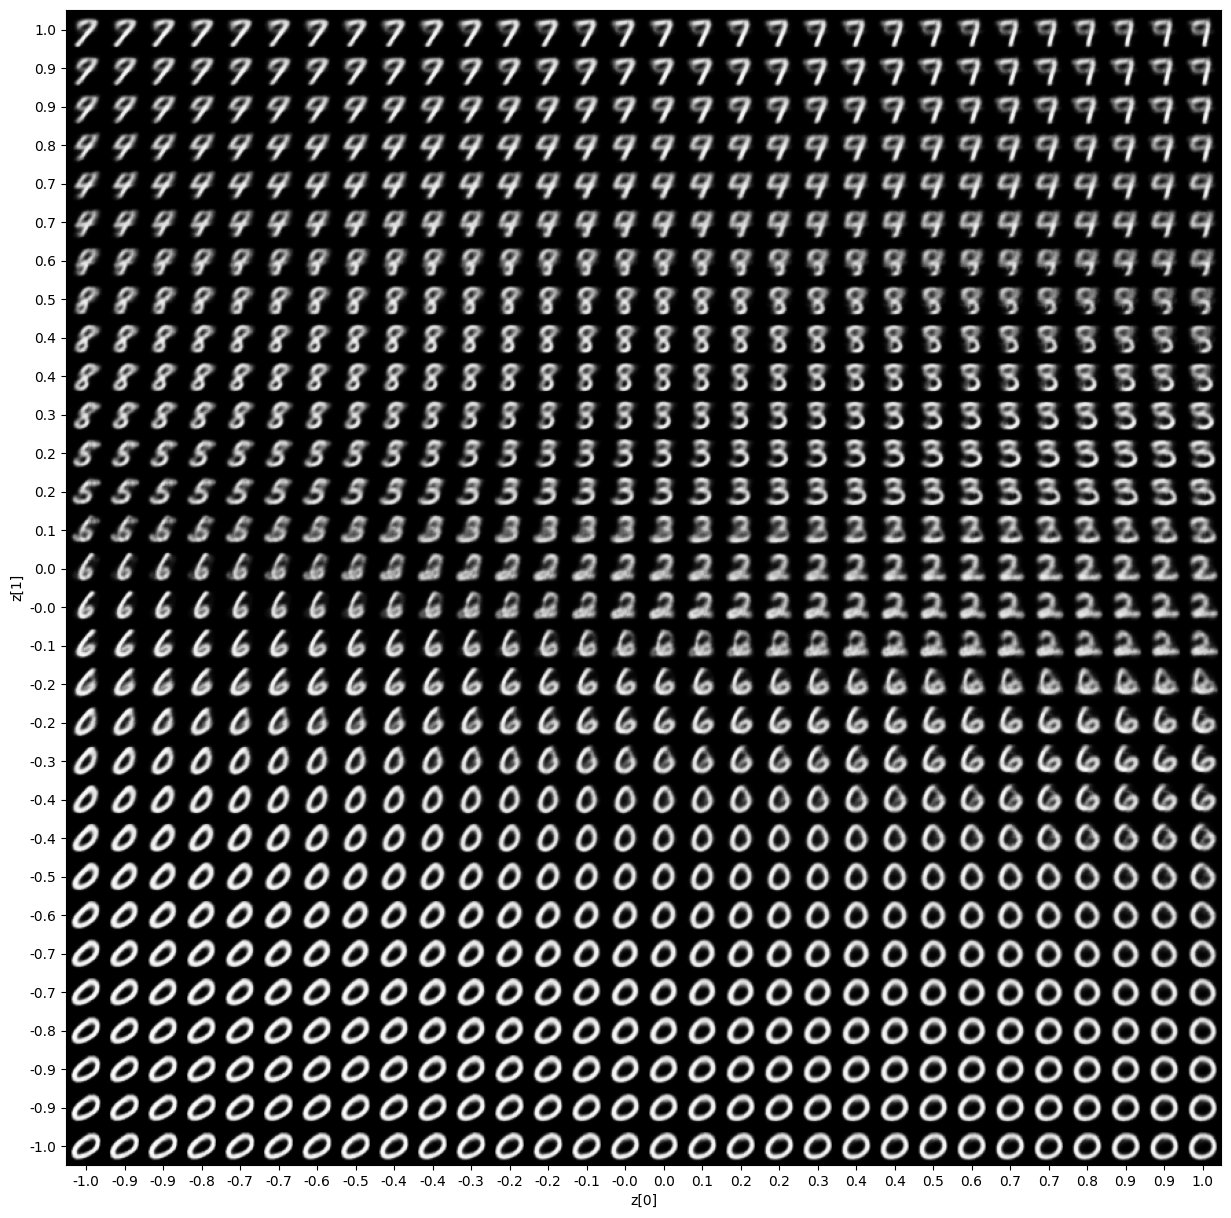

In [ ]:
def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample, verbose=0)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(vae)

In [ ]:
colors = ['red', 'green', 'blue', 'yellow', 'purple', 'orange', 'pink', 'brown', 'gray', 'cyan']

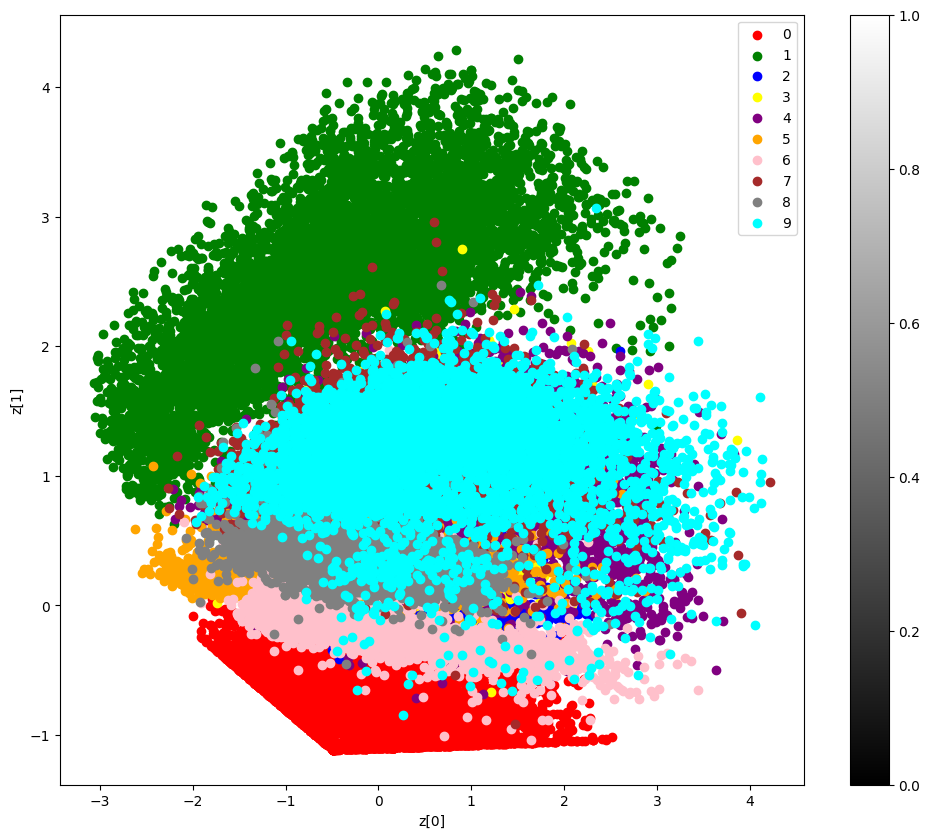

In [ ]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data, verbose=0)
    plt.figure(figsize=(12, 10))

    unique_labels = np.unique(labels)
    color_map = {label: colors[i] for i, label in enumerate(unique_labels)}

     # Scatter plot with custom colors
    for label in unique_labels:
      indices = np.where(labels == label)
      plt.scatter(z_mean[indices, 0], z_mean[indices, 1], c=color_map[label], label=label)

    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.legend()
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)